In [2]:
# Check Python libraries available on cluster
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package              Version
-------------------- ------------
appdirs              1.4.4
attrs                20.3.0
aws-cfn-bootstrap    2.0
awscli               2.14.5
awscrt               0.19.19
Babel                2.9.1
beautifulsoup4       4.9.3
boto                 2.49.0
cffi                 1.14.5
chardet              4.0.0
chevron              0.13.1
click                8.1.7
cloud-init           22.2.2
colorama             0.4.4
configobj            5.0.6
cryptography         36.0.1
dbus-python          1.2.18
distlib              0.3.1
distro               1.5.0
docutils             0.16
ec2-hibinit-agent    1.0.2
filelock             3.0.12
gpg                  1.15.1
idna                 2.10
Jinja2               2.11.3
jmespath             1.0.1
joblib               1.3.2
jsonpatch            1.21
jsonpointer          2.0
jsonschema           3.2.0
libcomps             0.1.18
lockfile             0.12.2
lxml                 4.9.3
MarkupSafe           1.1.1
mysqlclient

In [3]:
# Install necessary libraries
sc.install_pypi_package("pandas")
sc.install_pypi_package("matplotlib")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt1/yarn/usercache/livy/appcache/application_1704655206683_0001/container_1704655206683_0001_01_000001/tmp/spark-380e4578-6b18-494f-8821-4c953e0d00a8
    Can't uninstall 'python-dateutil'. No files were found to uninstall.




In [4]:
# Load libraries
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# Initialize SparkSession
spark = SparkSession.builder.appName("EMR Notebook").getOrCreate()

# Read data from S3
matches = spark.read.parquet("s3://processed-tennis-stats-data/matches")
players = spark.read.parquet("s3://processed-tennis-stats-data/players")
rankings = spark.read.parquet("s3://processed-tennis-stats-data/rankings")

matches.printSchema()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tourney_id: string (nullable = true)
 |-- tourney_name: string (nullable = true)
 |-- surface: string (nullable = true)
 |-- draw_size: long (nullable = true)
 |-- tourney_level: string (nullable = true)
 |-- tourney_date: date (nullable = true)
 |-- match_num: long (nullable = true)
 |-- winner_id: string (nullable = true)
 |-- winner_seed: string (nullable = true)
 |-- winner_entry: string (nullable = true)
 |-- winner_name: string (nullable = true)
 |-- winner_hand: string (nullable = true)
 |-- winner_ht: string (nullable = true)
 |-- winner_ioc: string (nullable = true)
 |-- winner_age: string (nullable = true)
 |-- loser_id: string (nullable = true)
 |-- loser_entry: string (nullable = true)
 |-- loser_name: string (nullable = true)
 |-- loser_hand: string (nullable = true)
 |-- loser_ht: double (nullable = true)
 |-- loser_ioc: string (nullable = true)
 |-- loser_age: double (nullable = true)
 |-- score: string (nullable = true)
 |-- best_of: long (nullable = true)
 |-

### Court surface win ratio

In [6]:
from pyspark.sql.functions import col, when

player = 'Daniil Medvedev'

# Filter records where 'winner_name' or 'loser_name' is equal to player
filtered_matches = matches.filter((col('winner_name') == player) | (col('loser_name') == player))

# Calculate win ratio based on surface
counts = (
    filtered_matches
    .select(
        'surface',
        when(col('winner_name') == 'Daniil Medvedev', 1).otherwise(0).alias('won_count'),
        when(col('loser_name') == 'Daniil Medvedev', 1).otherwise(0).alias('lost_count')
    )
    .groupBy('surface')
    .agg({'won_count': 'sum', 'lost_count': 'sum'})
    .withColumn('win_ratio', col('sum(won_count)') / col('sum(lost_count)'))
    .orderBy('surface')
)

# Show the resulting counts and ratios
counts.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------------+--------------+------------------+
|surface|sum(lost_count)|sum(won_count)|         win_ratio|
+-------+---------------+--------------+------------------+
| Carpet|              5|            12|               2.4|
|   Clay|             43|            71|1.6511627906976745|
|  Grass|             22|            50| 2.272727272727273|
|   Hard|            124|           348| 2.806451612903226|
+-------+---------------+--------------+------------------+

### Quality of serve depending on ranking

In [61]:
# Calculate winner 1st serve % for each record
matches = matches.withColumn('w_1st%', matches['w_1stIn'] / matches['w_svpt'] * 100) \
                 .withColumn('l_1st%', matches['l_1stIn'] / matches['l_svpt'] * 100)

# Calculate average winner 1st serve % for each ranking
w_1stp = (
    matches.filter(matches['tour'] == 'ATP')
    .groupBy('winner_rank')
    .agg({'w_1st%': 'avg'})
    .withColumnRenamed('avg(w_1st%)', 'w_avg_1st_percentage')
    .orderBy('winner_rank')
    .toPandas()
)

# Calculate average loser 1st serve % for each ranking
l_1stp = (
    matches.filter(matches['tour'] == 'ATP')
    .groupBy('loser_rank')
    .agg({'l_1st%': 'avg'})
    .withColumnRenamed('avg(l_1st%)', 'l_avg_1st_percentage')
    .orderBy('loser_rank')
    .toPandas()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
# Pre-process the DataFrames
# Drop NaNs
w_1stp.dropna(inplace=True)
l_1stp.dropna(inplace=True)
# Filter rankings outside of specified numbers
lower_rank = 1
upper_rank = 800
filtered_w_1stp = w_1stp[(w_1stp['winner_rank'] >= lower_rank) & (w_1stp['winner_rank'] <= upper_rank)]
filtered_l_1stp = l_1stp[(l_1stp['loser_rank'] >= lower_rank) & (l_1stp['loser_rank'] <= upper_rank)]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
# Extract data for plotting
winner_ranks = filtered_w_1stp['winner_rank']
w_avg_1st_percentages = filtered_w_1stp['w_avg_1st_percentage']

loser_ranks = filtered_l_1stp['loser_rank']
l_avg_1st_percentages = filtered_l_1stp['l_avg_1st_percentage']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

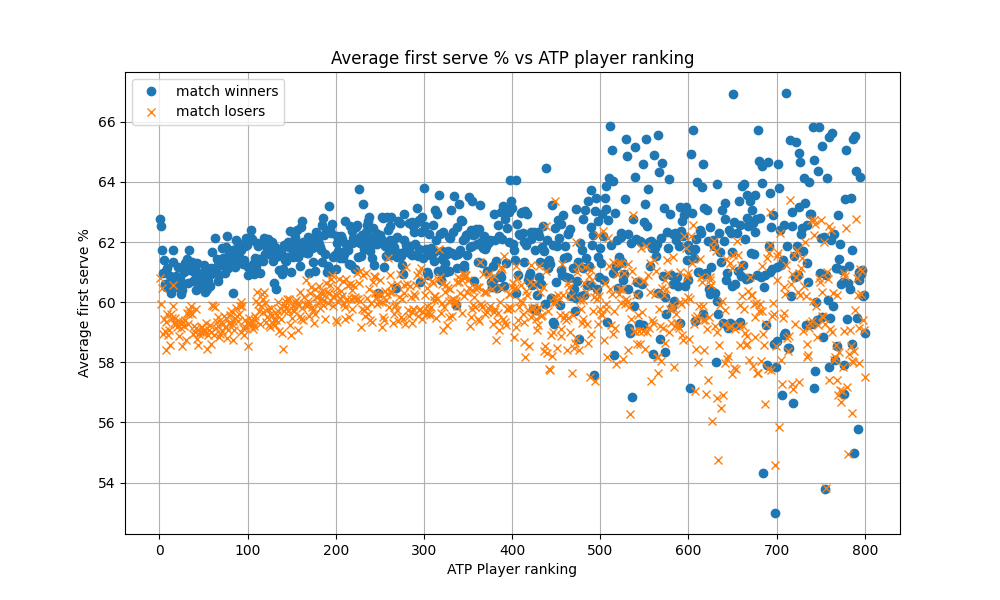

In [73]:
# Plotting using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(winner_ranks, w_avg_1st_percentages, marker='o', linestyle='', label='match winners')
ax.plot(loser_ranks, l_avg_1st_percentages, marker='x', linestyle='', label='match losers')
ax.set_xlabel('Player ATP ranking')
ax.set_ylabel('Average first serve %')
ax.set_title('Average first serve % vs player ATP ranking')
ax.grid(True)
ax.legend()
ax.set_xlim([lower_rank-40, upper_rank+40])
plt.show()
%matplot plt

#### Show player example quality serve trajectory

In [71]:
# Get trajectory of 1st serve percentage of player as he was climbing the ranking
player = 'Daniil Medvedev'

# Calculate average winner 1st serve % for each ranking
w_1stp_player = (
    matches.filter(matches['winner_name'] == player)
    .groupBy('winner_rank')
    .agg({'w_1st%': 'avg'})
    .withColumnRenamed('avg(w_1st%)', 'w_avg_1st_percentage')
    .orderBy('winner_rank')
    .toPandas()
)

# Calculate average loser 1st serve % for each ranking
l_1stp_player = (
    matches.filter(matches['loser_name'] == player)
    .groupBy('loser_rank')
    .agg({'l_1st%': 'avg'})
    .withColumnRenamed('avg(l_1st%)', 'l_avg_1st_percentage')
    .orderBy('loser_rank')
    .toPandas()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
# Calculate rolling average for better plottign for a single player
window_size = 10
w_1stp_player['running_average'] = w_1stp_player['w_avg_1st_percentage'].rolling(window=window_size, min_periods=5).mean()
l_1stp_player['running_average'] = l_1stp_player['l_avg_1st_percentage'].rolling(window=window_size, min_periods=5).mean()

# Extract data for plotting
wr_pl = w_1stp_player['winner_rank']
w1st_pl = w_1stp_player['running_average']

lr_pl = l_1stp_player['loser_rank']
l1st_pl = l_1stp_player['running_average']


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

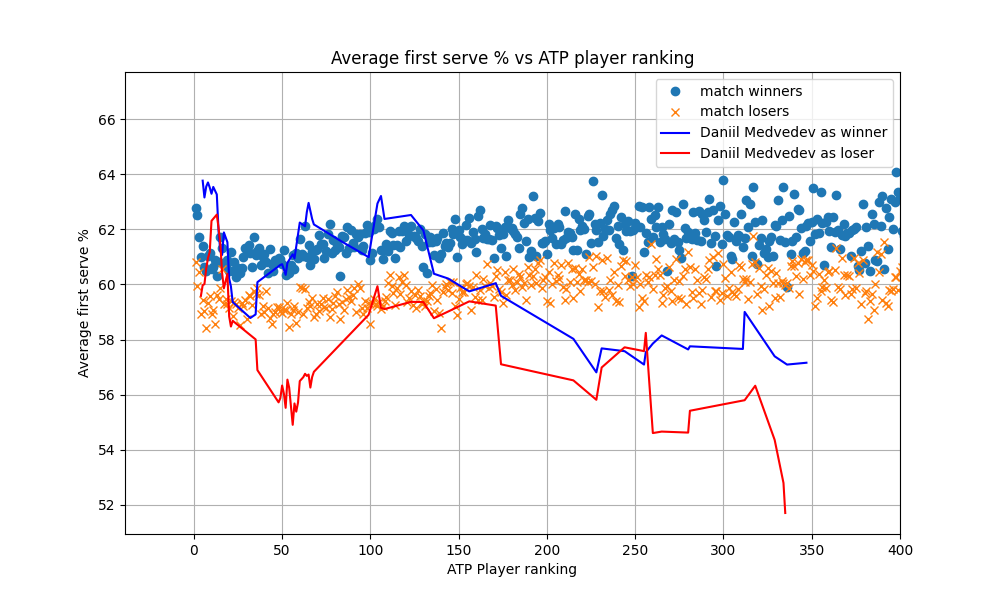

In [85]:
# Plotting using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(winner_ranks, w_avg_1st_percentages, marker='o', linestyle='', label='match winners')
ax.plot(loser_ranks, l_avg_1st_percentages, marker='x', linestyle='', label='match losers')
ax.plot(wr_pl, w1st_pl, 'b-', label=f'{player} as winner')
ax.plot(lr_pl, l1st_pl, 'r-', label=f'{player} as loser')
ax.set_xlabel('Player ATP ranking')
ax.set_ylabel('Average first serve %')
ax.set_title('Average first serve % vs player ATP ranking')
ax.grid(True)
ax.legend()
ax.set_xlim([lower_rank-40, 400])
plt.show()
%matplot plt

In [86]:
# Get trajectory of 1st serve percentage of player as he was climbing the ranking
player = 'Diego Schwartzman'

# Calculate average winner 1st serve % for each ranking
w_1stp_player = (
    matches.filter(matches['winner_name'] == player)
    .groupBy('winner_rank')
    .agg({'w_1st%': 'avg'})
    .withColumnRenamed('avg(w_1st%)', 'w_avg_1st_percentage')
    .orderBy('winner_rank')
    .toPandas()
)

# Calculate average loser 1st serve % for each ranking
l_1stp_player = (
    matches.filter(matches['loser_name'] == player)
    .groupBy('loser_rank')
    .agg({'l_1st%': 'avg'})
    .withColumnRenamed('avg(l_1st%)', 'l_avg_1st_percentage')
    .orderBy('loser_rank')
    .toPandas()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [87]:
# Calculate rolling average for better plottign for a single player
window_size = 10
w_1stp_player['running_average'] = w_1stp_player['w_avg_1st_percentage'].rolling(window=window_size, min_periods=5).mean()
l_1stp_player['running_average'] = l_1stp_player['l_avg_1st_percentage'].rolling(window=window_size, min_periods=5).mean()

# Extract data for plotting
wr_pl = w_1stp_player['winner_rank']
w1st_pl = w_1stp_player['running_average']

lr_pl = l_1stp_player['loser_rank']
l1st_pl = l_1stp_player['running_average']


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

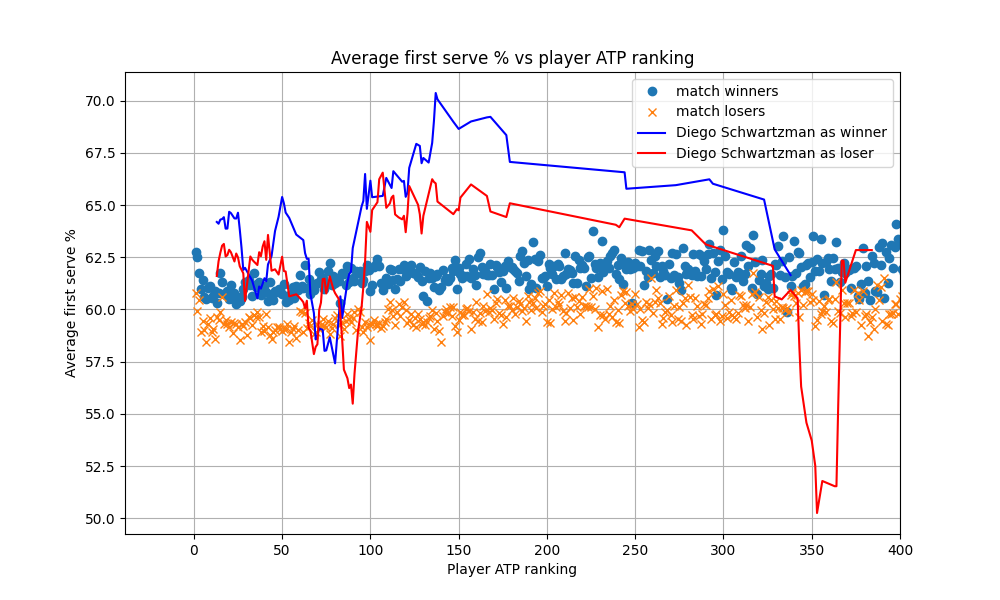

In [88]:
# Plotting using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(winner_ranks, w_avg_1st_percentages, marker='o', linestyle='', label='match winners')
ax.plot(loser_ranks, l_avg_1st_percentages, marker='x', linestyle='', label='match losers')
ax.plot(wr_pl, w1st_pl, 'b-', label=f'{player} as winner')
ax.plot(lr_pl, l1st_pl, 'r-', label=f'{player} as loser')
ax.set_xlabel('Player ATP ranking')
ax.set_ylabel('Average first serve %')
ax.set_title('Average first serve % vs player ATP ranking')
ax.grid(True)
ax.legend()
ax.set_xlim([lower_rank-40, 400])
plt.show()
%matplot plt